# Toy Factorization Experiment

> Can a simple encoder learn orthogonal pitch vs time directions in latent space?

**Idea**: Apply pitch-shifts and time-shifts to random blob images. Train a small ConvNet encoder
with a cosine-similarity loss that enforces:
- Same-type, same-sign shifts → **parallel** difference vectors (target +1)
- Same-type, opposite-sign shifts → **anti-parallel** difference vectors (target −1)
- Cross-type shifts → **orthogonal** difference vectors (target 0)

If it works, PCA of the difference vectors should show pitch and time axes separating cleanly.

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from tqdm.auto import trange
try: import wandb; HAS_WANDB = True
except ImportError: HAS_WANDB = False
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using {device}")

Using cpu


## Data: Random blob patches + augmentations

In [ ]:
def make_blob(sz=16, n_blobs=3):
    """Generate a random binary blob image (1, sz, sz)."""
    img = torch.zeros(1, sz, sz)
    for _ in range(n_blobs):
        r, c = torch.randint(0, sz-3, (2,))
        h, w = torch.randint(1, 4, (2,))
        img[0, r:r+h, c:c+w] = 1.0
    return img

def augment_batch(batch_size=64, sz=16, max_shift=4):
    """Returns anchor, crop1, crop2, targets, schemes, deltas1, deltas2 for a batch.
    Schemes: 0=pitch/pitch (blue), 1=time/time (green), 2=pitch+time (red)
    Deltas: (dy, dx) for each crop relative to anchor.
    """
    anchors, crop1s, crop2s, targets, schemes = [], [], [], [], []
    deltas1, deltas2 = [], []
    while len(anchors) < batch_size:
        img = make_blob(sz)
        scheme = torch.randint(0, 3, (1,)).item()
        s1 = torch.randint(1, max_shift+1, (1,)).item()
        s2 = torch.randint(1, max_shift+1, (1,)).item()
        sign1 = 1 if torch.rand(1) > 0.5 else -1
        sign2 = 1 if torch.rand(1) > 0.5 else -1
        if scheme == 0:    # two pitch shifts
            dy1, dx1 = sign1*s1, 0
            dy2, dx2 = sign2*s2, 0
        elif scheme == 1:  # two time shifts
            dy1, dx1 = 0, sign1*s1
            dy2, dx2 = 0, sign2*s2
        else:              # pitch + time
            dy1, dx1 = sign1*s1, 0
            dy2, dx2 = 0, sign2*s2
        c1 = torch.roll(img, shifts=dy1, dims=1)
        c1 = torch.roll(c1,  shifts=dx1, dims=2)
        c2 = torch.roll(img, shifts=dy2, dims=1)
        c2 = torch.roll(c2,  shifts=dx2, dims=2)
        if torch.equal(c1, c2): continue
        target = float(np.sign(sign1 * sign2)) if scheme < 2 else 0.0
        anchors.append(img); crop1s.append(c1); crop2s.append(c2)
        targets.append(target); schemes.append(scheme)
        deltas1.append((dy1, dx1)); deltas2.append((dy2, dx2))
    return (torch.stack(anchors), torch.stack(crop1s), torch.stack(crop2s),
            torch.tensor(targets), torch.tensor(schemes), deltas1, deltas2)

In [ ]:
def show_triplets(anchors, crop1s, crop2s, targets, schemes, deltas1, deltas2, n_rows=None):
    """Visualize triplets with colored borders and delta labels.
    Colors: blue=pitch/pitch, green=time/time, red=pitch+time.
    """
    from matplotlib.patches import Patch
    scheme_colors = {0: '#4488ff', 1: '#33bb55', 2: '#dd3333'}
    if n_rows is None: n_rows = len(anchors)
    n_rows = min(n_rows, len(anchors))

    fig, axes = plt.subplots(n_rows, 3, figsize=(10, n_rows * 2.2))
    if n_rows == 1: axes = axes[None]  # ensure 2D

    for i in range(n_rows):
        color = scheme_colors[schemes[i].item()]
        for j, (img, title) in enumerate(zip(
                [anchors[i], crop1s[i], crop2s[i]], ["Anchor", "Crop 1", "Crop 2"])):
            axes[i, j].imshow(img[0], cmap="gray", vmin=0, vmax=1)
            axes[i, j].set_title(title if i == 0 else "", fontsize=24)
            axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
            for spine in axes[i, j].spines.values():
                spine.set_color(color); spine.set_linewidth(2.5)
        dy1, dx1 = deltas1[i]
        dy2, dx2 = deltas2[i]
        axes[i, 1].set_ylabel(f"Δ({dy1:+d},{dx1:+d})", fontsize=20, color=color, fontweight='bold')
        axes[i, 2].set_ylabel(f"Δ({dy2:+d},{dx2:+d})", fontsize=20, color=color, fontweight='bold')

    legend_items = [
        Patch(facecolor='white', edgecolor='#4488ff', linewidth=3, label='Pitch only'),
        Patch(facecolor='white', edgecolor='#33bb55', linewidth=3, label='Time only'),
        Patch(facecolor='white', edgecolor='#dd3333', linewidth=3, label='Pitch + Time'),
    ]
    fig.legend(handles=legend_items, loc='lower center', ncol=3, fontsize=16,
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.06)
    plt.show()

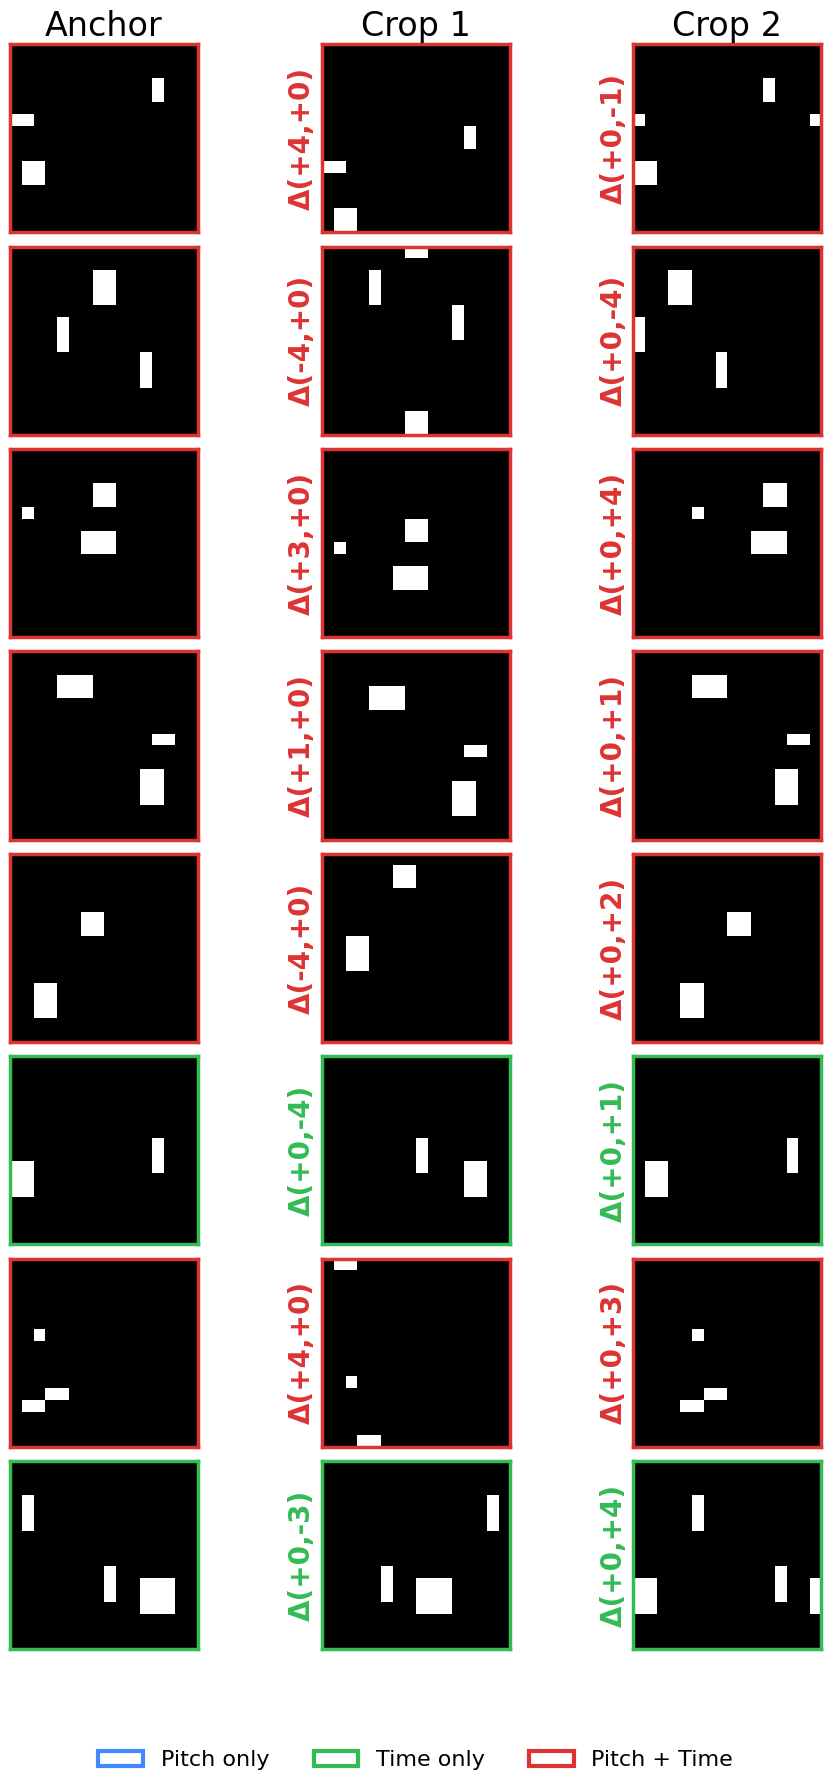

In [ ]:
# test code
a, c1, c2, t, s, d1, d2 = augment_batch(8)
show_triplets(a, c1, c2, t, s, d1, d2)

## Encoder: tiny ConvNet → latent vector

In [ ]:
class ToyEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),  # 16x16
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),  # 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),  # 4x4
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(64, latent_dim),
        )
    def forward(self, x): return self.net(x)

enc = ToyEncoder().to(device)
print(f"Params: {sum(p.numel() for p in enc.parameters()):,}")

Params: 23,816


## Loss: cosine factorization objective

In [ ]:
def factorization_loss(z_anchor, z_crop1, z_crop2, targets):
    """Cosine-similarity loss on difference vectors.
    targets: +1 (parallel), -1 (anti-parallel), 0 (orthogonal)
    """
    d1 = z_crop1 - z_anchor  # (B, D)
    d2 = z_crop2 - z_anchor  # (B, D)
    cos = F.cosine_similarity(d1, d2, dim=-1)  # (B,)
    return ((cos - targets) ** 2).mean()

## Training loop

In [ ]:
def train(enc, n_steps=2000, batch_size=128, lr=1e-3, log_every=100, use_wandb=False):
    opt = torch.optim.Adam(enc.parameters(), lr=lr)
    if use_wandb and HAS_WANDB:
        wandb.init(project="toy-factorization", config=dict(n_steps=n_steps, batch_size=batch_size, lr=lr, latent_dim=8))
    losses = []
    for step in range(n_steps):
        a, c1, c2, t = augment_batch(batch_size)
        a, c1, c2, t = a.to(device), c1.to(device), c2.to(device), t.to(device)
        za, z1, z2 = enc(a), enc(c1), enc(c2)
        loss = factorization_loss(za, z1, z2, t)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
        if step % log_every == 0:
            print(f"step {step:4d}  loss={loss.item():.4f}")
            if use_wandb and HAS_WANDB: wandb.log({"loss": loss.item(), "step": step})
    if use_wandb and HAS_WANDB: wandb.finish()
    return losses

Okay, we might need to modify that training code now since we changed how the augmentation batch works. And we need to convert from the returned deltas to the target to be sent to the loss function. Can you help do that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right! The main issue is that the training loop still tries to unpack 4 values:

```python
a, c1, c2, t = augment_batch(batch_size)
```

but now `augment_batch` returns 7. The simplest fix is just updating the unpacking:

```python
a, c1, c2, t, s, d1, d2 = augment_batch(batch_size)
```

Since `targets` is still returned directly, that's all that's strictly needed. But — are you thinking you'd rather compute the targets *from* the deltas instead (to match how your real `PRPairDataset` works)? That would make the toy experiment a closer mirror of the real pipeline.

Yeah, I mean, if we're returning the deltas, then we don't really need to return that T thing, I guess. But, I mean, this is just a toy model, so who cares? Yeah, your line is probably fine.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good call — let's keep it simple. You just need to change that one unpacking line in `train`. Want to update it, or shall I regenerate the whole `train` function?

In [ ]:
losses = train(enc, n_steps=2000, use_wandb=False)

## Loss curve

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(losses, alpha=0.3, label='raw')
plt.plot(np.convolve(losses, np.ones(50)/50, mode='valid'), label='smoothed')
plt.xlabel('step'); plt.ylabel('loss'); plt.legend(); plt.title('Factorization Loss')
plt.tight_layout(); plt.show()

## Visualization: do pitch & time difference vectors separate?

In [ ]:
@torch.no_grad()
def collect_diff_vectors(enc, n=500, sz=16, max_shift=4):
    """Collect difference vectors for pitch-only and time-only shifts."""
    pitch_diffs, time_diffs = [], []
    for _ in range(n):
        img = make_blob(sz).unsqueeze(0).to(device)
        s = torch.randint(1, max_shift+1, (1,)).item()
        sign = 1 if torch.rand(1) > 0.5 else -1
        za = enc(img)
        zp = enc(torch.roll(img, shifts=sign*s, dims=2))  # pitch = vertical
        pitch_diffs.append((zp - za).squeeze().cpu())
        zt = enc(torch.roll(img, shifts=sign*s, dims=3))  # time = horizontal
        time_diffs.append((zt - za).squeeze().cpu())
    return torch.stack(pitch_diffs), torch.stack(time_diffs)

pitch_d, time_d = collect_diff_vectors(enc)
print(f"Collected: pitch={pitch_d.shape}, time={time_d.shape}")

In [ ]:
from sklearn.decomposition import PCA

all_diffs = torch.cat([pitch_d, time_d], dim=0).numpy()
labels = ['pitch'] * len(pitch_d) + ['time'] * len(time_d)
pca = PCA(n_components=2).fit(all_diffs)
proj = pca.transform(all_diffs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA scatter
ax = axes[0]
n = len(pitch_d)
ax.scatter(proj[:n, 0], proj[:n, 1], alpha=0.3, s=10, label='pitch Δ', c='blue')
ax.scatter(proj[n:, 0], proj[n:, 1], alpha=0.3, s=10, label='time Δ', c='red')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.legend(); ax.set_title('PCA of difference vectors')
ax.set_aspect('equal')

# Cross-type cosine similarity histogram
cos_cross = F.cosine_similarity(pitch_d, time_d, dim=-1).numpy()
cos_pitch = F.cosine_similarity(pitch_d[::2], pitch_d[1::2], dim=-1).numpy()
ax = axes[1]
ax.hist(cos_cross, bins=40, alpha=0.5, label='pitch vs time (want ≈0)', density=True)
ax.hist(cos_pitch, bins=40, alpha=0.5, label='pitch vs pitch (want ≈±1)', density=True)
ax.set_xlabel('cosine similarity'); ax.legend(); ax.set_title('Cosine similarity distributions')

plt.tight_layout(); plt.show()
print(f"Mean |cos(pitch,time)|: {np.abs(cos_cross).mean():.3f}  (ideal: 0)")
print(f"Mean |cos(pitch,pitch)|: {np.abs(cos_pitch).mean():.3f}  (ideal: 1)")

## Next steps

If the PCA plot shows two distinct clusters/directions and the cosine histograms look good:
- ✅ The factorization objective works — proceed to integrate into the real training code
- Try varying `latent_dim` to see minimum dimensionality needed
- Try adding noise to the blobs to test robustness

If it **doesn't** work:
- Check if the loss is actually decreasing
- Try more training steps or lower lr
- Consider adding a small reconstruction or contrastive anchor term to prevent collapse

Where is the data getting where's the wannabe? Oh